<a href="https://colab.research.google.com/github/czengnn/lana-del-rey-lyrics-generator/blob/main/LDR_by_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [1]:
import pandas as pd 
import numpy as np 
import re 
import os
import time
import matplotlib.pyplot as plt

import tensorflow as tf
import keras 
print(tf.__version__)
print(keras.__version__)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.losses import sparse_categorical_crossentropy

from keras.models import Sequential
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, Bidirectional
from keras.callbacks import ModelCheckpoint


2.4.1
2.4.3


In [2]:
# load songs
songs1 = pd.read_csv('/content/drive/MyDrive/data/lana_lyrics_83.csv').drop('Unnamed: 0', axis=1)
songs2 = pd.read_csv('/content/drive/MyDrive/data/lana_lyrics_15.csv').drop('Unnamed: 0', axis=1)
songs = pd.concat([songs1, songs2], axis=0)
songs.shape

(98, 2)

In [3]:
# put lyrics into 1 string
text = ''
for song in songs['lyrics']:
    text = text + song.lower()
    
# remove the text with brackets around them, such as [Verse 1]
text = re.sub(r'\[[^][]*\]', '', text)

In [4]:
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

Length of text: 161722 characters
61 unique characters


In [5]:
corpus = list(set(text.lower().split('\n')))
corpus[:5]

['',
 'yo soy la princesa, comprende mis white lines',
 "your halo's full of fire",
 'i just wanna dance with you',
 'nobody stopped to hеar him']

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print(total_words)

2575


In [7]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
input_sequences[20:30]

In [9]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding='pre'))

In [12]:
input_sequences[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  578, 1327],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  578, 1327,   85]], dtype=int32)

In [13]:
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
predictors.shape

(17490, 17)

### Building The Model

In [38]:
from keras import backend as K
K.clear_session()

def sparse_cat_loss(y_true,y_pred):
    return sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)

vocab_size = total_words
embed_dim = 50
def create_model(vocab_size, embed_dim):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, input_length=max_sequence_len-1))

    # Add an LSTM Layer
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    # A dropout layer for regularisation
    model.add(Dropout(0.1))
    # Add another LSTM Layer
    model.add(LSTM(256,return_sequences=True)) 
    model.add(Dropout(0.1))
    model.add(LSTM(128,return_sequences=False))
    model.add(Dense(vocab_size//2, activation='relu'))
    # In the last layer, the shape should be equal to the total number of words present in our corpus
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss=sparse_cat_loss, optimizer='adam', metrics='accuracy')
    return model

model = create_model(vocab_size, embed_dim)
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 17, 50)            128750    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 17, 1024)          2306048   
_________________________________________________________________
dropout_12 (Dropout)         (None, 17, 1024)          0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 17, 256)           1311744   
_________________________________________________________________
dropout_13 (Dropout)         (None, 17, 256)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_16 (Dense)             (None, 1287)             

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(predictors, label, epochs=200, verbose=1, callbacks=[early_stopping])

# Save the weights
model.save_weights('/content/drive/MyDrive/data/models/ldr_by_word/ldr_by_word')

Epoch 1/200
547/547 [==============================] - 8s 14ms/step - loss: 1.2222 - accuracy: 0.6431
Epoch 2/200
547/547 [==============================] - 8s 14ms/step - loss: 1.2102 - accuracy: 0.6467
Epoch 3/200
547/547 [==============================] - 8s 15ms/step - loss: 1.2145 - accuracy: 0.6430
Epoch 4/200
547/547 [==============================] - 8s 15ms/step - loss: 1.1945 - accuracy: 0.6489
Epoch 5/200
547/547 [==============================] - 8s 15ms/step - loss: 1.1741 - accuracy: 0.6583
Epoch 6/200
547/547 [==============================] - 8s 15ms/step - loss: 1.1636 - accuracy: 0.6598
Epoch 7/200
547/547 [==============================] - 8s 15ms/step - loss: 1.1410 - accuracy: 0.6638
Epoch 8/200
547/547 [==============================] - 8s 15ms/step - loss: 1.1386 - accuracy: 0.6660
Epoch 9/200
547/547 [==============================] - 8s 15ms/step - loss: 1.1107 - accuracy: 0.6727
Epoch 10/200
547/547 [==============================] - 8s 15ms/step - loss: 1.109

In [46]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


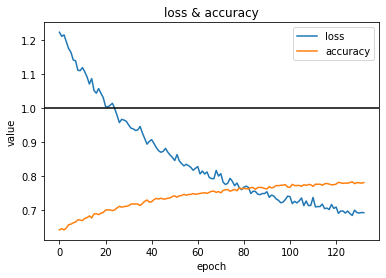

In [50]:
# summarize history for accuracy
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.axhline(y=1, color='k')
plt.title('loss & accuracy')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend()
plt.show()

#### Recreate the model and load saved weights

In [63]:
# Create a new model instance
model_loaded = create_model(vocab_size, embed_dim)
model_loaded.load_weights('/content/drive/MyDrive/data/models/ldr_by_word/ldr_by_word')

In [43]:
def make_lyrics(model, seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list],
                     maxlen=max_sequence_len-1,padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [60]:
predicted_lyrics = make_lyrics(model, 'ice cream', 100)
print(predicted_lyrics)

ice cream ice queen of many bonnie's blue if you were so much better divine away it hazy the oh when i my eyes are wide drinkin' gold can leather life you're born to keep me once i while no one that's why then everything you say he schnapps with a while is lit never warns up rising up when i was curtain tuerais grow cold outside babe is hard on put your life fire of my baby swinging with the top but when you're standin' in infamy feels like my veins yeah yeah oh shatter yeah oh yeah oh yeah oh


In [57]:
predicted_lyrics = make_lyrics(model, 'james dean', 100)
print(predicted_lyrics)

james dean for memory damn days sports car and do it for forever find one of your legacy i'm usually night 'bout you really know that i write a las vegas eyes are to change baby again at you for you so much on the train platform golden brown on that follow me through these halls all 2 life baby again at heart and can of your vogues and all of your rolling stones slippin' on your side that's the things to come come to get baby without they now i'm cursed never hot weather in the tv changes and seasons wow


In [61]:
predicted_lyrics = make_lyrics(model, 'queen of', 100)
print(predicted_lyrics)

queen of coney island crazy at both ends you do it well i'm your little bambi eyes dreams i'm your national anthem god hymn don't be a fuckin' mess in from everywhere i am i hurts on he ain't on put more up straight to you i'll do we music turns that no more skippin' past like jim '90s in it hot hot weather in the spring i love you honey away my tar black hair used to yes of mind you do it feel like the ah your walls even able to you i'll always make it hard but you keep


In [62]:
predicted_lyrics = make_lyrics(model, 'park', 100)
print(predicted_lyrics)

park making me everything's okay ay babe yeah 'bout it from the spring i feel it at your whole world is so always like it like a minute night yeah you blame the news he prays for love he prays for peace and maybe someone new coat on the spring i love track of the right thing to from a woman are hard to wait to me alive again at you do was read do he in the sky with the real that's agree powerful beings hot weather in the spring i me baby we need to start diamonds on a


In [34]:
predicted_lyrics = make_lyrics(model_loaded, 'california', 50)
print(predicted_lyrics)

california dreamin' got my little red sports car what you like just if you do i can't see myself having veyron of it like a vitamin when i hold you forever just take me there and be my tiny dancer baby by my once in a lifetime manifesto violet pills on
